Semantic Segmentation 
============

In this exercise you are going to work on a computer vision task called semantic segmentation. In comparison to image classification the goal is not to classify an entire image but each of its pixels separately. This implies that the  output of the network is not a single scalar but a segmentation with the same shape as the input image. Think about why you should rather use convolutional than fully-connected layers for this task!

<img src="https://camo.githubusercontent.com/d10b897e15344334e449104a824aff6c29125dc2/687474703a2f2f63616c76696e2e696e662e65642e61632e756b2f77702d636f6e74656e742f75706c6f6164732f646174612f636f636f7374756666646174617365742f636f636f73747566662d6578616d706c65732e706e67">

## (Optional) Mount folder in Colab

Uncomment the following cell to mount your gdrive if you are using the notebook in google colab:

In [1]:
# Use the following lines if you want to use Google Colab
# We presume you created a folder "i2dl" within your main drive folder, and put the exercise there.
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct exercise folder (e.g exercise_10) is given.


from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/i2dl/exercise_10'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))


Mounted at /content/gdrive
['.ipynb_checkpoints', '.tmp', '1_segmentation_nn.ipynb', 'exercise_code', 'images']


### Set up PyTorch environment in colab
- (OPTIONAL) Enable GPU via Runtime --> Change runtime type --> GPU
- Uncomment the following cell if you are using the notebook in google colab:

In [3]:
# Optional: install correct libraries in google colab
#!python -m pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html
#!python -m pip install tensorboard==2.8.0
#!python -m pip install pytorch-lightning==1.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████▎               | 834.1 MB 1.3 MB/s eta 0:10:08tcmalloc: large alloc 1147494400 bytes == 0x3a6aa000 @  0x7f4da40dd615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████▋           | 1055.7 MB 1.3 MB/s eta 0:07:34tcmalloc: large alloc 1434370048 bytes == 0x7ed00000 @  0x7f4da40dd615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████

In [2]:
import sys

# For google colab
# !python -m pip install pytorch-lightning==1.6.0 > /dev/null
# !pip install --upgrade torchvision
# For anaconda/regular python
# !{sys.executable} -m pip install pytorch-lightning==1.6.0 > /dev/null
# 1. Preparation

## Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

from exercise_code.data.segmentation_dataset import SegmentationData, label_img_to_rgb
from exercise_code.data.download_utils import download_dataset
from exercise_code.util import visualizer, save_model
from exercise_code.util.Util import checkSize, checkParams, test
from exercise_code.networks.segmentation_nn import SegmentationNN, DummySegmentationModel
from exercise_code.tests import test_seg_nn
#set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
device

device(type='cuda', index=0)

## Setup TensorBoard
In exercise 07 you've already learned how to use TensorBoard. Let's use it again to make the debugging of our network and training process more convenient! Throughout this notebook, feel free to add further logs or visualizations to your TensorBoard!

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs --port 6006

## Load and Visualize Data

#### MSRC-v2 Segmentation Dataset

The MSRC v2 dataset is an extension of the MSRC v1 dataset from Microsoft Research in Cambridge. It contains *591* images and *23* object classes with accurate pixel-wise labeled images. 



The image ids are stored in the txt file `train.txt`, `val.txt`, `test.txt`. The dataloader will read the image id in the txt file and fetch the corresponding input and target images from the image folder. 

<img src='images/input_target.png'/>



As you can see in `exercise_code/data/segmentation_dataset.py`, each segmentation label has its corresponding RGB value stored in the `SEG_LABELS_LIST`. The label `void` means `unlabeled`, and it is displayed as black `"rgb_values": [0, 0, 0]` in the target image. The target image pixels will be labeled based on its color using `SEG_LABELS_LIST`.

```python
                SEG_LABELS_LIST = [
                {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
                {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
                {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
                {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
                {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
                {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
                {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
                ...]    
```

<div class="alert alert-block alert-warning">
    <h3>Note: The label <code>void</code></h3>
    <p>Pixels with the label <code>void</code> should neither be considered in your loss nor in the accuracy of your segmentation. See implementation for details.</p>
</div>

In [5]:
download_url = 'https://i2dl.dvl.in.tum.de/downloads/segmentation_data.zip'
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(i2dl_exercises_path, 'datasets','segmentation')


download_dataset(
    url=download_url,
    data_dir=data_root,
    dataset_zip_name='segmentation_data.zip',
    force_download=False,
)

train_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/train.txt')
val_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/val.txt')
test_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/test.txt')

75841536it [00:03, 20063124.11it/s]                              


If you want to implement data augmentation methods, make yourself familiar with the segmentation dataset and how we implemented the `SegmentationData` class in `exercise_code/data/segmentation_dataset.py`. Furthermore, you can check the original label description in `datasets/segmentation/segmentation_data/info.html`.

For now, let's look at a few samples of our training set:

Train size: 276
Validation size: 59
Img size:  torch.Size([3, 240, 240])
Segmentation size:  torch.Size([240, 240])


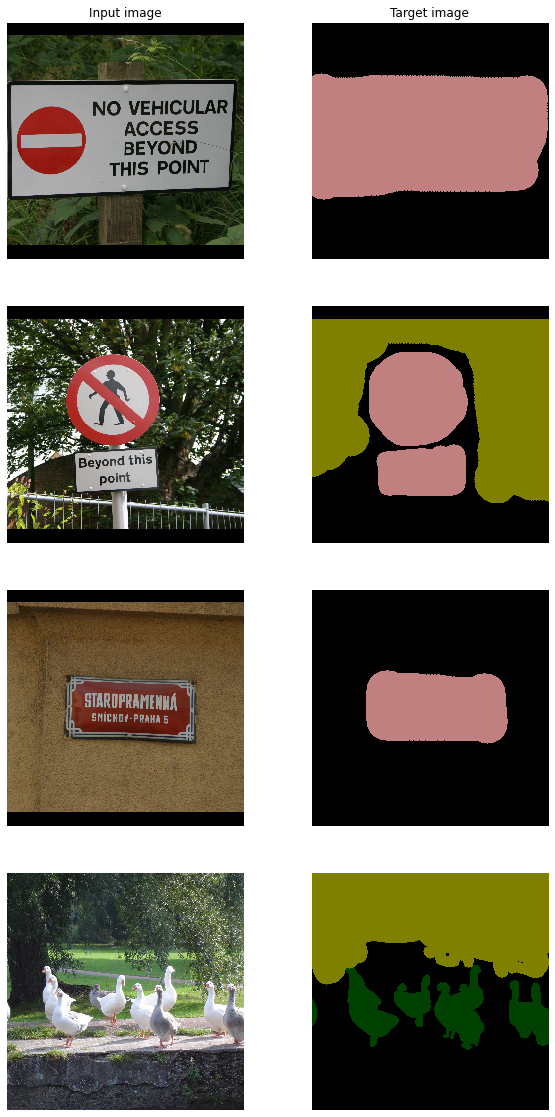

In [6]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 4
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    plt.imshow(label_img_to_rgb(target.numpy()))
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

We can already see that the dataset is quite small in comparison to our previous datasets, e.g., for CIFAR10 we had ten thousands of images while we only have 276 training images in this case. In addition, the task is much more difficult than a "simple 10 class classification", as we have to assign a label to each pixel! What's more, the images are much bigger as we are now considering images of size 240x240 instead of 32x32. 

That means that you shouldn't expect our networks to perform very well, so don't be too disappointed.

# 2. Semantic Segmentation 

## Dummy Model

In `exercise_code/networks/segmentation_nn.py` we define a naive `DummySegmentationModel`, which always predicts the scores of segmentation labels of the first image. Let's try it on a few images and visualize the outputs using the `visualizer` we provide. The `visualizer` takes in the model and dataset, and visualizes the first four (Input, Target, Prediction) pairs. 

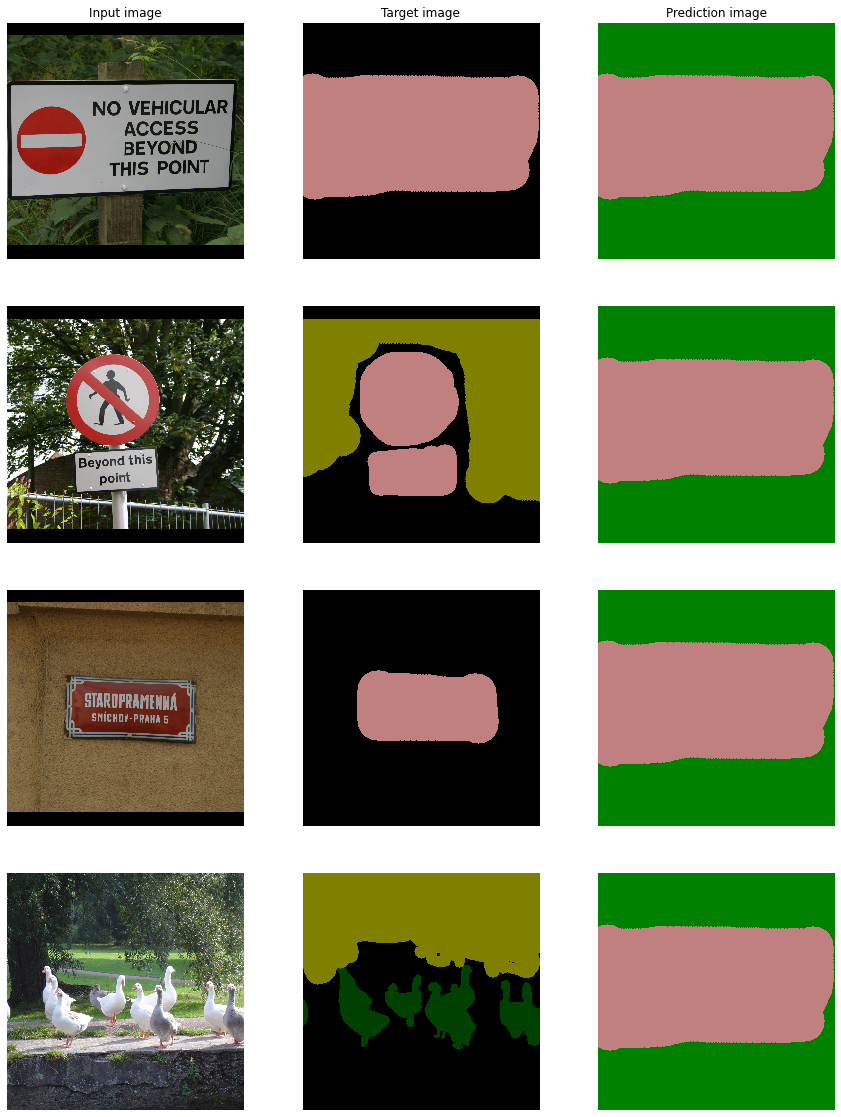

In [7]:
dummy_model = DummySegmentationModel(target_image=train_data[0][1])

# Visualization function
visualizer(dummy_model, train_data)

You can use the visualizer function in your training scenario to print out your model predictions on a regular basis.

## Loss and Metrics
The loss function for the task of image segmentation is a pixel-wise cross entropy loss. This loss examines each pixel individually, comparing the class predictions (depth-wise pixel vector) to our one-hot encoded target vector. 
<img src='images/loss_img.png' width=80% height=80%/>
source: https://www.jeremyjordan.me/semantic-segmentation/

Up until now we only used the default loss function (`nn.CrossEntropyLoss`) in our solvers. However, In order to ignore the `unlabeled` pixels for the computation of our loss, we have to use a customized version of the loss for the initialization of our segmentation solver. The `ignore_index` argument of the loss can be used to filter the `unlabeled` pixels and computes the loss only over remaining pixels.


In [8]:
loss_func = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='mean')

for (inputs, targets) in train_data[0:4]:
    inputs, targets = inputs, targets
    outputs = dummy_model(inputs.unsqueeze(0))
    losses = loss_func(outputs, targets.unsqueeze(0))
    print(losses)

tensor(2.2075)
tensor(2.9404)
tensor(2.2075)
tensor(3.2075)


### Note: Non-zero loss for the first sample
The output of our dummy model is one-hot-coded tensor. Since there is `softmax` function in the `nn.CrossEntropyLoss` function, the loss is:  
    $$loss(x, class) = - \log \left( \frac{\exp(x[class])}{\Sigma_j \exp (x[j])} \right) = −x[class]+\log \left( \Sigma_j \exp(x[j]) \right)$$
     and the loss will not be zero.  

To obtain an evaluation accuracy, we can simply compute the average per pixel accuracy of our network for a given image. We will use the following function:

In [9]:
def evaluate_model(model, dataloader):
    test_scores = []
    model.eval()
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model.forward(inputs)
        _, preds = torch.max(outputs, 1)
        targets_mask = targets >= 0
        test_scores.append(np.mean((preds.cpu() == targets.cpu())[targets_mask].numpy()))

    return np.mean(test_scores)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=False,num_workers=0)
print(evaluate_model(dummy_model, test_loader))

0.14179702232915609


You will see reasonably high numbers as your accuracy when you do the training later. The reason behind that is the fact that most output pixels are of a single class and the network can just overfit to common classes such as "grass".

## Step 1: Design your own model

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement your network architecture in <code>exercise_code/networks/segmentation_nn.py</code>. In this task, you will use pytorch to setup your model.
    </p>
</div>

To compensate for the dimension reduction of a typical convolution layer, you should probably include either a single `nn.Upsample` layer, use a combination of upsampling layers as well as convolutions or even transposed convolutions near the end of your network to get back to the target image shape.

This file is mostly empty but contains the expected class name, and the methods that your model needs to implement (only `forward()` basically). 
The only rules your model design has to follow are:
* Inherit from `torch.nn.Module` or `pytorch_lightning.LightningModule`
* Perform the forward pass in `forward()`. Input dimension is (N, C, H, W) and output dimension is (N, num_classes, H, W)
* Have less than 5 million parameters
* Have a model size of less than 50MB after saving

Furthermore, you need to pass all your hyperparameters to the model in a single dict `hparams`.

<div class="alert alert-warning">
    <h3>Note: Transfer learning</h3>
    <p>In this exercise, we encourage you to do transfer learning as we learned in exercise 8, since this will boost your model performance and save training time. You can import pretrained models from torchvision in your model and use its feature extractor (e.g. <code>alexnet.features</code>) to get the image feature. Feel free to choose more advanced pretrained model like ResNet, MobileNet for your architecture design.</p>       
</div>

See [here](https://pytorch.org/vision/stable/models.html) for more info of the torchvison pretrained models.


In [10]:
hparams = {
    # TODO: if you have any model arguments/hparams, define them here and read them from this dict inside SegmentationNN class
          "num_filters" : 128,
           "kernel_size" : 3,
           "padding" : 1,
           "stride" : 1,
           "lr" : 1e-3,
           "batch_size" : 4,
           "epoch":150
}

In [14]:
model = SegmentationNN(hparams = hparams)
test_seg_nn(model)

ParamCountTest passed. Your model has 2.258 mio. params.
FileSizeTest passed. Your model is 9.0 MB large
All tests passed for your model. Tests passed: 2/2


In [15]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=hparams["batch_size"], shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=hparams["batch_size"], shuffle=False)
optimizer = torch.optim.Adam(model.parameters(), lr=hparams["lr"], weight_decay=0.1*hparams["lr"])

## Step 2: Train your own model

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p> In addition to the network itself, you will also need to write the code for the model training. You can use PyTorch Lightning for that, or you can also write it yourself in standard PyTorch.
    </p>
</div>

In [18]:
model = SegmentationNN(hparams=hparams)
########################################################################
# TODO - Train Your Model                                              #
########################################################################

import torch.optim as optim
import torch.optim as optim
from torch import nn
from torch.autograd import Variable
from tqdm import tqdm

def train_net(n_epoch):

    for epoch in range(n_epoch): 
        print(epoch)
        running_loss = 0.0
        for i, (inputs, targets) in tqdm(enumerate(train_loader, 1)):
          
            
            images, targets = Variable(inputs), Variable(targets)

            inputs, targets = images.to("cuda"), targets.to("cuda")

        
            outputs = model(inputs)
         

            loss = loss_func(outputs, targets)

           
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()

         
            running_loss += loss.item()
            if i % 10 == 9:    
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1,
                                                                   i+1,
                                                                   running_loss / (len(train_loader)*epoch+i)))

    print('Finished Training')
    
model = SegmentationNN(hparams=hparams)
model = model.to("cuda")
loss_func = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='mean')
optimizer = optim.Adam(model.parameters(), betas=([0.9, 0.999]), lr=0.001, weight_decay=1e-08)
train_net(n_epoch=150)
# #######################################################################
# #                           END OF YOUR CODE                          #
# #######################################################################

0


9it [00:07,  1.24it/s]

Epoch: 1, Batch: 10, Avg. Loss: 3.03202125761244


18it [00:13,  1.29it/s]


1


9it [00:07,  1.27it/s]

Epoch: 2, Batch: 10, Avg. Loss: 0.8835793689445213


18it [00:13,  1.32it/s]


2


9it [00:07,  1.26it/s]

Epoch: 3, Batch: 10, Avg. Loss: 0.4922941949632433


18it [00:13,  1.32it/s]


3


9it [00:07,  1.27it/s]

Epoch: 4, Batch: 10, Avg. Loss: 0.34144617262340726


18it [00:13,  1.33it/s]


4


9it [00:07,  1.28it/s]

Epoch: 5, Batch: 10, Avg. Loss: 0.24891526610762985


18it [00:13,  1.33it/s]


5


9it [00:07,  1.12it/s]

Epoch: 6, Batch: 10, Avg. Loss: 0.20253075493706596


18it [00:14,  1.25it/s]


6


9it [00:07,  1.28it/s]

Epoch: 7, Batch: 10, Avg. Loss: 0.159719666864118


18it [00:13,  1.32it/s]


7


9it [00:07,  1.26it/s]

Epoch: 8, Batch: 10, Avg. Loss: 0.1491979475374575


18it [00:13,  1.32it/s]


8


9it [00:07,  1.28it/s]

Epoch: 9, Batch: 10, Avg. Loss: 0.12345945367626115


18it [00:13,  1.33it/s]


9


9it [00:07,  1.28it/s]

Epoch: 10, Batch: 10, Avg. Loss: 0.10971629968163563


18it [00:13,  1.34it/s]


10


9it [00:07,  1.28it/s]

Epoch: 11, Batch: 10, Avg. Loss: 0.09786359658316961


18it [00:13,  1.33it/s]


11


9it [00:07,  1.22it/s]

Epoch: 12, Batch: 10, Avg. Loss: 0.08376605844728037


18it [00:14,  1.25it/s]


12


9it [00:07,  1.27it/s]

Epoch: 13, Batch: 10, Avg. Loss: 0.07917246023813883


18it [00:13,  1.32it/s]


13


9it [00:07,  1.27it/s]

Epoch: 14, Batch: 10, Avg. Loss: 0.07281736532847087


18it [00:13,  1.33it/s]


14


9it [00:07,  1.28it/s]

Epoch: 15, Batch: 10, Avg. Loss: 0.06477569665945353


18it [00:13,  1.33it/s]


15


9it [00:07,  1.27it/s]

Epoch: 16, Batch: 10, Avg. Loss: 0.057508078527279655


18it [00:13,  1.33it/s]


16


9it [00:07,  1.28it/s]

Epoch: 17, Batch: 10, Avg. Loss: 0.05550720234109898


18it [00:13,  1.33it/s]


17


9it [00:07,  1.28it/s]

Epoch: 18, Batch: 10, Avg. Loss: 0.04942858824654231


18it [00:14,  1.25it/s]


18


9it [00:07,  1.28it/s]

Epoch: 19, Batch: 10, Avg. Loss: 0.046697953083851676


18it [00:13,  1.33it/s]


19


9it [00:07,  1.28it/s]

Epoch: 20, Batch: 10, Avg. Loss: 0.044660827373167726


18it [00:13,  1.33it/s]


20


9it [00:07,  1.28it/s]

Epoch: 21, Batch: 10, Avg. Loss: 0.04275511984579609


18it [00:13,  1.33it/s]


21


9it [00:07,  1.28it/s]

Epoch: 22, Batch: 10, Avg. Loss: 0.03913063627188828


18it [00:13,  1.33it/s]


22


9it [00:07,  1.29it/s]

Epoch: 23, Batch: 10, Avg. Loss: 0.03718083110856421


18it [00:13,  1.33it/s]


23


9it [00:07,  1.27it/s]

Epoch: 24, Batch: 10, Avg. Loss: 0.03416185767938059


18it [00:13,  1.33it/s]


24


9it [00:07,  1.23it/s]

Epoch: 25, Batch: 10, Avg. Loss: 0.031779564427140077


18it [00:14,  1.25it/s]


25


9it [00:07,  1.24it/s]

Epoch: 26, Batch: 10, Avg. Loss: 0.03168208043299989


18it [00:13,  1.32it/s]


26


9it [00:07,  1.28it/s]

Epoch: 27, Batch: 10, Avg. Loss: 0.028830889635865792


18it [00:13,  1.33it/s]


27


9it [00:07,  1.28it/s]

Epoch: 28, Batch: 10, Avg. Loss: 0.02882139321529504


18it [00:13,  1.33it/s]


28


9it [00:07,  1.28it/s]

Epoch: 29, Batch: 10, Avg. Loss: 0.025635499470879924


18it [00:13,  1.33it/s]


29


9it [00:07,  1.28it/s]

Epoch: 30, Batch: 10, Avg. Loss: 0.026100906499586088


18it [00:13,  1.33it/s]


30


9it [00:07,  1.07it/s]

Epoch: 31, Batch: 10, Avg. Loss: 0.023830696099008584


18it [00:14,  1.24it/s]


31


9it [00:07,  1.27it/s]

Epoch: 32, Batch: 10, Avg. Loss: 0.023321917868585604


18it [00:13,  1.33it/s]


32


9it [00:07,  1.28it/s]

Epoch: 33, Batch: 10, Avg. Loss: 0.022581216412731725


18it [00:13,  1.33it/s]


33


9it [00:07,  1.28it/s]

Epoch: 34, Batch: 10, Avg. Loss: 0.022561567932812134


18it [00:13,  1.34it/s]


34


9it [00:07,  1.28it/s]

Epoch: 35, Batch: 10, Avg. Loss: 0.020006200733584098


18it [00:13,  1.34it/s]


35


9it [00:07,  1.27it/s]

Epoch: 36, Batch: 10, Avg. Loss: 0.01947720882851566


18it [00:13,  1.33it/s]


36


9it [00:07,  1.28it/s]

Epoch: 37, Batch: 10, Avg. Loss: 0.01943489169784151


18it [00:14,  1.25it/s]


37


9it [00:07,  1.27it/s]

Epoch: 38, Batch: 10, Avg. Loss: 0.01878714331874141


18it [00:13,  1.33it/s]


38


9it [00:07,  1.26it/s]

Epoch: 39, Batch: 10, Avg. Loss: 0.01745780756291201


18it [00:13,  1.33it/s]


39


9it [00:07,  1.28it/s]

Epoch: 40, Batch: 10, Avg. Loss: 0.017995243837058795


18it [00:13,  1.33it/s]


40


9it [00:07,  1.28it/s]

Epoch: 41, Batch: 10, Avg. Loss: 0.01606721299175372


18it [00:13,  1.34it/s]


41


9it [00:07,  1.27it/s]

Epoch: 42, Batch: 10, Avg. Loss: 0.015695640680142037


18it [00:13,  1.33it/s]


42


9it [00:07,  1.27it/s]

Epoch: 43, Batch: 10, Avg. Loss: 0.015014226919685314


18it [00:14,  1.28it/s]


43


9it [00:07,  1.27it/s]

Epoch: 44, Batch: 10, Avg. Loss: 0.014496791408436509


18it [00:13,  1.31it/s]


44


9it [00:07,  1.26it/s]

Epoch: 45, Batch: 10, Avg. Loss: 0.015003706483209922


18it [00:13,  1.33it/s]


45


9it [00:07,  1.28it/s]

Epoch: 46, Batch: 10, Avg. Loss: 0.01443692543276646


18it [00:13,  1.33it/s]


46


9it [00:07,  1.27it/s]

Epoch: 47, Batch: 10, Avg. Loss: 0.012750251888516698


18it [00:13,  1.33it/s]


47


9it [00:07,  1.27it/s]

Epoch: 48, Batch: 10, Avg. Loss: 0.013846715291341146


18it [00:13,  1.33it/s]


48


9it [00:07,  1.29it/s]

Epoch: 49, Batch: 10, Avg. Loss: 0.012443676915228845


18it [00:13,  1.33it/s]


49


9it [00:07,  1.16it/s]

Epoch: 50, Batch: 10, Avg. Loss: 0.0119950036809902


18it [00:14,  1.25it/s]


50


9it [00:07,  1.28it/s]

Epoch: 51, Batch: 10, Avg. Loss: 0.011050145421484516


18it [00:13,  1.33it/s]


51


9it [00:07,  1.28it/s]

Epoch: 52, Batch: 10, Avg. Loss: 0.010669405406346985


18it [00:13,  1.33it/s]


52


9it [00:07,  1.27it/s]

Epoch: 53, Batch: 10, Avg. Loss: 0.011427018377516005


18it [00:13,  1.32it/s]


53


9it [00:06,  1.28it/s]

Epoch: 54, Batch: 10, Avg. Loss: 0.010700854247480414


18it [00:13,  1.34it/s]


54


9it [00:06,  1.29it/s]

Epoch: 55, Batch: 10, Avg. Loss: 0.010457097815689568


18it [00:13,  1.34it/s]


55


9it [00:07,  1.27it/s]

Epoch: 56, Batch: 10, Avg. Loss: 0.009686416453188724


18it [00:14,  1.25it/s]


56


9it [00:07,  1.25it/s]

Epoch: 57, Batch: 10, Avg. Loss: 0.00958446186904007


18it [00:13,  1.32it/s]


57


9it [00:07,  1.28it/s]

Epoch: 58, Batch: 10, Avg. Loss: 0.009150945103686789


18it [00:13,  1.33it/s]


58


9it [00:07,  1.28it/s]

Epoch: 59, Batch: 10, Avg. Loss: 0.009500683203042403


18it [00:13,  1.33it/s]


59


9it [00:07,  1.27it/s]

Epoch: 60, Batch: 10, Avg. Loss: 0.008575952798823793


18it [00:13,  1.33it/s]


60


9it [00:07,  1.28it/s]

Epoch: 61, Batch: 10, Avg. Loss: 0.00908277837150791


18it [00:13,  1.34it/s]


61


9it [00:07,  1.28it/s]

Epoch: 62, Batch: 10, Avg. Loss: 0.008513637836063457


18it [00:14,  1.27it/s]


62


9it [00:07,  1.24it/s]

Epoch: 63, Batch: 10, Avg. Loss: 0.007873568110995823


18it [00:13,  1.31it/s]


63


9it [00:07,  1.28it/s]

Epoch: 64, Batch: 10, Avg. Loss: 0.007571214192391276


18it [00:13,  1.34it/s]


64


9it [00:07,  1.28it/s]

Epoch: 65, Batch: 10, Avg. Loss: 0.007957767711231977


18it [00:13,  1.34it/s]


65


9it [00:07,  1.28it/s]

Epoch: 66, Batch: 10, Avg. Loss: 0.00749339134234104


18it [00:13,  1.33it/s]


66


9it [00:07,  1.28it/s]

Epoch: 67, Batch: 10, Avg. Loss: 0.006965578598286972


18it [00:13,  1.33it/s]


67


9it [00:07,  1.27it/s]

Epoch: 68, Batch: 10, Avg. Loss: 0.007434529532130363


18it [00:13,  1.33it/s]


68


9it [00:07,  1.23it/s]

Epoch: 69, Batch: 10, Avg. Loss: 0.007220868018228449


18it [00:14,  1.25it/s]


69


9it [00:07,  1.27it/s]

Epoch: 70, Batch: 10, Avg. Loss: 0.006795784647611501


18it [00:13,  1.32it/s]


70


9it [00:07,  1.27it/s]

Epoch: 71, Batch: 10, Avg. Loss: 0.006916647966308233


18it [00:13,  1.32it/s]


71


9it [00:07,  1.26it/s]

Epoch: 72, Batch: 10, Avg. Loss: 0.006890284709441356


18it [00:13,  1.32it/s]


72


9it [00:07,  1.28it/s]

Epoch: 73, Batch: 10, Avg. Loss: 0.00694808512355176


18it [00:13,  1.33it/s]


73


9it [00:07,  1.28it/s]

Epoch: 74, Batch: 10, Avg. Loss: 0.006062604898047645


18it [00:13,  1.33it/s]


74


9it [00:07,  1.19it/s]

Epoch: 75, Batch: 10, Avg. Loss: 0.005750802983818083


18it [00:14,  1.25it/s]


75


9it [00:07,  1.25it/s]

Epoch: 76, Batch: 10, Avg. Loss: 0.0058257742959668835


18it [00:13,  1.31it/s]


76


9it [00:07,  1.27it/s]

Epoch: 77, Batch: 10, Avg. Loss: 0.0060808280714197095


18it [00:13,  1.32it/s]


77


9it [00:07,  1.27it/s]

Epoch: 78, Batch: 10, Avg. Loss: 0.005659655089019448


18it [00:13,  1.33it/s]


78


9it [00:07,  1.27it/s]

Epoch: 79, Batch: 10, Avg. Loss: 0.005584750965142706


18it [00:13,  1.33it/s]


79


9it [00:07,  1.27it/s]

Epoch: 80, Batch: 10, Avg. Loss: 0.005168480859779129


18it [00:13,  1.33it/s]


80


9it [00:07,  1.12it/s]

Epoch: 81, Batch: 10, Avg. Loss: 0.005040688215246523


18it [00:14,  1.25it/s]


81


9it [00:07,  1.28it/s]

Epoch: 82, Batch: 10, Avg. Loss: 0.004957669107948101


18it [00:13,  1.33it/s]


82


9it [00:07,  1.27it/s]

Epoch: 83, Batch: 10, Avg. Loss: 0.005075850470700248


18it [00:13,  1.33it/s]


83


9it [00:07,  1.28it/s]

Epoch: 84, Batch: 10, Avg. Loss: 0.0052875464785836655


18it [00:13,  1.34it/s]


84


9it [00:07,  1.29it/s]

Epoch: 85, Batch: 10, Avg. Loss: 0.0044048581367883925


18it [00:13,  1.33it/s]


85


9it [00:07,  1.28it/s]

Epoch: 86, Batch: 10, Avg. Loss: 0.004499873261392852


18it [00:13,  1.33it/s]


86


9it [00:07,  1.04it/s]

Epoch: 87, Batch: 10, Avg. Loss: 0.004621143400783943


18it [00:14,  1.25it/s]


87


9it [00:07,  1.27it/s]

Epoch: 88, Batch: 10, Avg. Loss: 0.0044434198122175915


18it [00:13,  1.33it/s]


88


9it [00:07,  1.29it/s]

Epoch: 89, Batch: 10, Avg. Loss: 0.004375300576532703


18it [00:13,  1.33it/s]


89


9it [00:07,  1.27it/s]

Epoch: 90, Batch: 10, Avg. Loss: 0.0040728341415755724


18it [00:13,  1.32it/s]


90


9it [00:07,  1.27it/s]

Epoch: 91, Batch: 10, Avg. Loss: 0.004021905623307764


18it [00:13,  1.33it/s]


91


9it [00:07,  1.26it/s]

Epoch: 92, Batch: 10, Avg. Loss: 0.004060173584753336


18it [00:13,  1.32it/s]


92


9it [00:07,  1.09it/s]

Epoch: 93, Batch: 10, Avg. Loss: 0.003985188565812669


18it [00:14,  1.25it/s]


93


9it [00:07,  1.28it/s]

Epoch: 94, Batch: 10, Avg. Loss: 0.003973990979820791


18it [00:13,  1.33it/s]


94


9it [00:07,  1.28it/s]

Epoch: 95, Batch: 10, Avg. Loss: 0.003953626371705483


18it [00:13,  1.34it/s]


95


9it [00:06,  1.29it/s]

Epoch: 96, Batch: 10, Avg. Loss: 0.0038212422994488267


18it [00:13,  1.34it/s]


96


9it [00:07,  1.28it/s]

Epoch: 97, Batch: 10, Avg. Loss: 0.0035211495373121404


18it [00:13,  1.33it/s]


97


9it [00:07,  1.26it/s]

Epoch: 98, Batch: 10, Avg. Loss: 0.0035082033217123092


18it [00:13,  1.32it/s]


98


9it [00:07,  1.27it/s]

Epoch: 99, Batch: 10, Avg. Loss: 0.003243618642147557


18it [00:14,  1.24it/s]


99


9it [00:07,  1.27it/s]

Epoch: 100, Batch: 10, Avg. Loss: 0.003480061181492808


18it [00:13,  1.32it/s]


100


9it [00:07,  1.26it/s]

Epoch: 101, Batch: 10, Avg. Loss: 0.003210058589216225


18it [00:13,  1.32it/s]


101


9it [00:07,  1.27it/s]

Epoch: 102, Batch: 10, Avg. Loss: 0.0030608246348631076


18it [00:13,  1.32it/s]


102


9it [00:07,  1.27it/s]

Epoch: 103, Batch: 10, Avg. Loss: 0.003216199209373495


18it [00:13,  1.32it/s]


103


9it [00:07,  1.26it/s]

Epoch: 104, Batch: 10, Avg. Loss: 0.002871663898021639


18it [00:13,  1.32it/s]


104


9it [00:07,  1.27it/s]

Epoch: 105, Batch: 10, Avg. Loss: 0.0032627894991195815


18it [00:14,  1.25it/s]


105


9it [00:07,  1.28it/s]

Epoch: 106, Batch: 10, Avg. Loss: 0.0030927471012238013


18it [00:13,  1.33it/s]


106


9it [00:07,  1.27it/s]

Epoch: 107, Batch: 10, Avg. Loss: 0.0028716132208028685


18it [00:13,  1.33it/s]


107


9it [00:07,  1.26it/s]

Epoch: 108, Batch: 10, Avg. Loss: 0.00293617019049573


18it [00:13,  1.32it/s]


108


9it [00:07,  1.28it/s]

Epoch: 109, Batch: 10, Avg. Loss: 0.002507103920837457


18it [00:13,  1.33it/s]


109


9it [00:07,  1.26it/s]

Epoch: 110, Batch: 10, Avg. Loss: 0.0025984612532160356


18it [00:13,  1.33it/s]


110


9it [00:07,  1.28it/s]

Epoch: 111, Batch: 10, Avg. Loss: 0.0024852795238888043


18it [00:14,  1.27it/s]


111


9it [00:07,  1.27it/s]

Epoch: 112, Batch: 10, Avg. Loss: 0.0024887043769287126


18it [00:13,  1.30it/s]


112


9it [00:07,  1.28it/s]

Epoch: 113, Batch: 10, Avg. Loss: 0.0022724959585401746


18it [00:13,  1.33it/s]


113


9it [00:07,  1.27it/s]

Epoch: 114, Batch: 10, Avg. Loss: 0.0026465103548062065


18it [00:13,  1.32it/s]


114


9it [00:07,  1.28it/s]

Epoch: 115, Batch: 10, Avg. Loss: 0.0024394337006531427


18it [00:13,  1.33it/s]


115


9it [00:07,  1.28it/s]

Epoch: 116, Batch: 10, Avg. Loss: 0.002221278527311662


18it [00:13,  1.34it/s]


116


9it [00:07,  1.27it/s]

Epoch: 117, Batch: 10, Avg. Loss: 0.002241259935530925


18it [00:13,  1.33it/s]


117


9it [00:08,  1.22it/s]

Epoch: 118, Batch: 10, Avg. Loss: 0.0021869319550534513


18it [00:14,  1.24it/s]


118


9it [00:07,  1.27it/s]

Epoch: 119, Batch: 10, Avg. Loss: 0.002127950592774267


18it [00:13,  1.32it/s]


119


9it [00:07,  1.28it/s]

Epoch: 120, Batch: 10, Avg. Loss: 0.002130779290077355


18it [00:13,  1.33it/s]


120


9it [00:07,  1.26it/s]

Epoch: 121, Batch: 10, Avg. Loss: 0.0024003393230156837


18it [00:13,  1.31it/s]


121


9it [00:07,  1.29it/s]

Epoch: 122, Batch: 10, Avg. Loss: 0.0017918088308577676


18it [00:13,  1.34it/s]


122


9it [00:07,  1.27it/s]

Epoch: 123, Batch: 10, Avg. Loss: 0.0020079773164390167


18it [00:13,  1.32it/s]


123


9it [00:07,  1.16it/s]

Epoch: 124, Batch: 10, Avg. Loss: 0.0017380952111139955


18it [00:14,  1.24it/s]


124


9it [00:07,  1.28it/s]

Epoch: 125, Batch: 10, Avg. Loss: 0.0019066982479938063


18it [00:13,  1.33it/s]


125


9it [00:07,  1.29it/s]

Epoch: 126, Batch: 10, Avg. Loss: 0.0017048477097494827


18it [00:13,  1.33it/s]


126


9it [00:07,  1.29it/s]

Epoch: 127, Batch: 10, Avg. Loss: 0.0016271930071780909


18it [00:13,  1.34it/s]


127


9it [00:07,  1.28it/s]

Epoch: 128, Batch: 10, Avg. Loss: 0.001682895305109959


18it [00:13,  1.34it/s]


128


9it [00:07,  1.28it/s]

Epoch: 129, Batch: 10, Avg. Loss: 0.001604287772790931


18it [00:13,  1.34it/s]


129


9it [00:07,  1.05it/s]

Epoch: 130, Batch: 10, Avg. Loss: 0.0015731498260244388


18it [00:14,  1.25it/s]


130


9it [00:06,  1.29it/s]

Epoch: 131, Batch: 10, Avg. Loss: 0.0015752167588043537


18it [00:13,  1.34it/s]


131


9it [00:07,  1.28it/s]

Epoch: 132, Batch: 10, Avg. Loss: 0.0018061012168146156


18it [00:13,  1.33it/s]


132


9it [00:07,  1.28it/s]

Epoch: 133, Batch: 10, Avg. Loss: 0.0017509702116688343


18it [00:13,  1.33it/s]


133


9it [00:06,  1.29it/s]

Epoch: 134, Batch: 10, Avg. Loss: 0.001968077332389092


18it [00:13,  1.33it/s]


134


9it [00:07,  1.27it/s]

Epoch: 135, Batch: 10, Avg. Loss: 0.001718852292009249


18it [00:13,  1.33it/s]


135


9it [00:06,  1.29it/s]

Epoch: 136, Batch: 10, Avg. Loss: 0.0014297393024236562


18it [00:14,  1.26it/s]


136


9it [00:07,  1.28it/s]

Epoch: 137, Batch: 10, Avg. Loss: 0.0013954532937300995


18it [00:13,  1.33it/s]


137


9it [00:07,  1.28it/s]

Epoch: 138, Batch: 10, Avg. Loss: 0.0014784415442534167


18it [00:13,  1.33it/s]


138


9it [00:07,  1.27it/s]

Epoch: 139, Batch: 10, Avg. Loss: 0.0013324951747790237


18it [00:13,  1.33it/s]


139


9it [00:06,  1.28it/s]

Epoch: 140, Batch: 10, Avg. Loss: 0.0012720500577830167


18it [00:13,  1.34it/s]


140


9it [00:07,  1.28it/s]

Epoch: 141, Batch: 10, Avg. Loss: 0.0013854791520376269


18it [00:13,  1.33it/s]


141


9it [00:07,  1.28it/s]

Epoch: 142, Batch: 10, Avg. Loss: 0.001356341351375048


18it [00:14,  1.26it/s]


142


9it [00:07,  1.27it/s]

Epoch: 143, Batch: 10, Avg. Loss: 0.0012307556168145372


18it [00:13,  1.32it/s]


143


9it [00:07,  1.27it/s]

Epoch: 144, Batch: 10, Avg. Loss: 0.0014656332173275477


18it [00:13,  1.33it/s]


144


9it [00:07,  1.26it/s]

Epoch: 145, Batch: 10, Avg. Loss: 0.0011311532247071081


18it [00:13,  1.33it/s]


145


9it [00:07,  1.28it/s]

Epoch: 146, Batch: 10, Avg. Loss: 0.001161157265561553


18it [00:13,  1.33it/s]


146


9it [00:07,  1.28it/s]

Epoch: 147, Batch: 10, Avg. Loss: 0.0010746205603484181


18it [00:13,  1.33it/s]


147


9it [00:07,  1.27it/s]

Epoch: 148, Batch: 10, Avg. Loss: 0.0010198103337638123


18it [00:13,  1.32it/s]


148


9it [00:07,  1.25it/s]

Epoch: 149, Batch: 10, Avg. Loss: 0.0010269712384969967


18it [00:14,  1.26it/s]


149


9it [00:07,  1.27it/s]

Epoch: 150, Batch: 10, Avg. Loss: 0.0010571891448170844


18it [00:13,  1.33it/s]

Finished Training


# 3. Test your Model

In [19]:
test(evaluate_model(model, test_loader))

Validation-Accuracy: 67.48813528645287%
Congrats! The accuracy passes the threshold, you can try to submit your model to server now.


# 4. Visualization

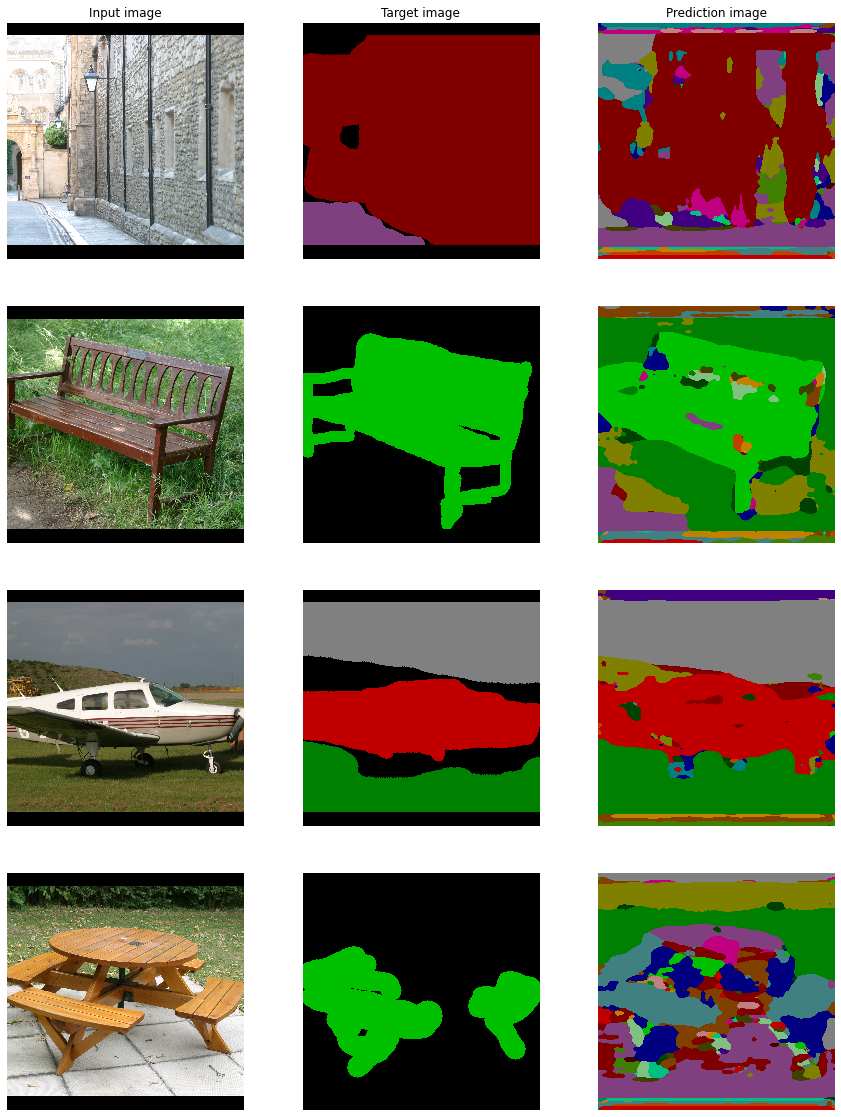

In [20]:
visualizer(model, test_data)

## Save the Model for Submission

When you are satisfied with your training, save the model for [submission](https://i2dl.dvl.in.tum.de/submission/). In order to be eligible for the bonus points you have to achieve an accuracy above __64%__.

In [21]:
os.makedirs('models', exist_ok=True)
save_model(model, "segmentation_nn.model")
checkSize(path = "./models/segmentation_nn.model")

Great! Your model size is less than 50 MB and will be accepted :)


True

In [22]:
from exercise_code.util.submit import submit_exercise

submit_exercise('../output/exercise10')

relevant folders: ['exercise_code', 'models']
notebooks files: ['1_segmentation_nn.ipynb']
Adding folder exercise_code
Adding folder models
Adding notebook 1_segmentation_nn.ipynb
Zipping successful! Zip is stored under: /content/gdrive/MyDrive/i2dl/output/exercise10.zip


# Submission Instructions

Congratulations! You've just built your first semantic segmentation model with PyTorch Lightning! To complete the exercise, submit your final model to our submission portal - you probably know the procedure by now.

1. Go on [our submission page](https://i2dl.dvl.in.tum.de/submission/), register for an account and login. We use your matriculation number and send an email with the login details to the mail account associated. When in doubt, login into tum online and check your mails there. You will get an ID which we need in the next step.
2. Log into [our submission page](https://i2dl.dvl.in.tum.de/submission/) with your account details and upload the `zip` file. Once successfully uploaded, you should be able to see the submitted file selectable on the top.
3. Click on this file and run the submission script. You will get an email with your score as well as a message if you have surpassed the threshold.

# Submission Goals

- Goal: Implement and train a convolutional neural network for Semantic Segmentation.
- Passing Criteria: Reach **Accuracy >= 64%** on __our__ test dataset. The submission system will show you your score after you submit.
- Submission start: __Tuesday, July 12, 2022__
- Submission deadline: __Monday, July 18, 2022 - 23:59__
- You can make **$\infty$** submissions until the deadline. Your __best submission__ will be considered for bonus

# [Exercise Review](https://docs.google.com/forms/d/e/1FAIpQLScwZArz6ogLqBEj--ItB6unKcv0u9gWLj8bspeiATrDnFH9hA/viewform)

We are always interested in your opinion. Now that you have finished this exercise, we would like you to give us some feedback about the time required to finish the submission and/or work through the notebooks. Please take the short time to fill out our [review form](https://docs.google.com/forms/d/e/1FAIpQLScwZArz6ogLqBEj--ItB6unKcv0u9gWLj8bspeiATrDnFH9hA/viewform) for this exercise so that we can do better next time! :)